# Assignment 4

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

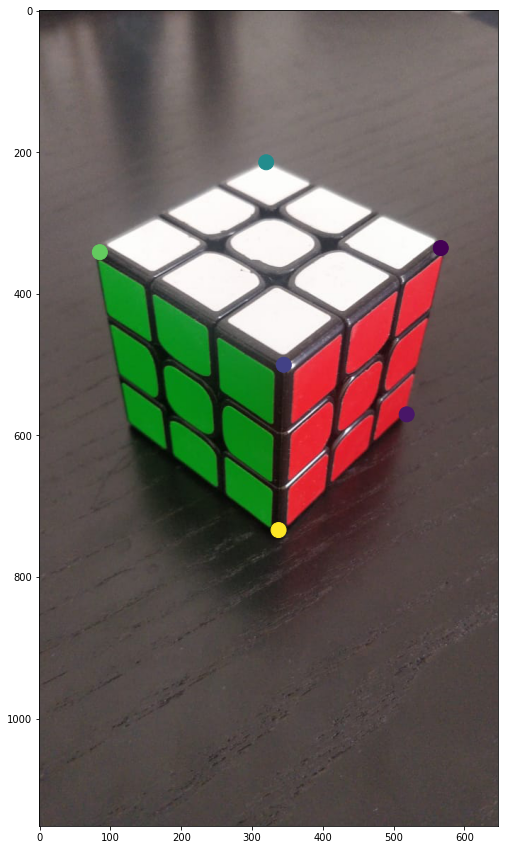

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
x = image_points
print("Image points : \n",x)

X = [[0,0,0],[4,0,0],[4,0,-4],[0,0,-4],[4,-4,0], [4, -4, -4]]
X = np.array(X)
print("3D World points : \n",X)

Image points : 
 [[ 84.99914476 341.04957238]
 [344.81035793 500.14745011]
 [566.67161863 335.21111815]
 [319.99692746 214.0631929 ]
 [337.51229015 733.68561926]
 [518.50437124 570.20890086]]
3D World points : 
 [[ 0  0  0]
 [ 4  0  0]
 [ 4  0 -4]
 [ 0  0 -4]
 [ 4 -4  0]
 [ 4 -4 -4]]


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
# Helper functions
# appends a ones column to input
def hom_coords(x, X):
    n = x.shape[0]
    size = (n, 1)
    ones = np.ones(size)
    x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    return x, X


x, X = hom_coords(x, X)

In [5]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    A = []
    n = X.shape[0] 
    #for k in range(0,n): n = 6
    for i in range(n):
        xt,yt,zt = X[i,0],X[i,1],X[i,2]
        u,v = x[i,0],x[i,1]
        A.append( [-xt, -yt, -zt, -1, 0, 0, 0, 0, u * xt, u * yt, u * zt, u] )
        A.append( [0, 0, 0, 0, -xt, -yt, -zt, -1, v * xt, v * yt, v * zt, v] )
    
    # Convert A to array
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A) 
    P = V[-1,:]/V[-1,-1]
    #P = np.random.randn(3,4)
    P = P.reshape(3,4)
    
    return P

P = DLT(x,X)
print('Projection matrix : \n' , P , type(P) , P.shape)

Projection matrix : 
 [[ 5.49810303e+01 -1.85543172e+01 -7.14889141e+01  8.49614193e+01]
 [ 2.53111388e+01 -9.54903524e+01  2.32017896e+01  3.40979089e+02]
 [-2.90354277e-02 -5.99045118e-02 -3.97522244e-02  1.00000000e+00]] <class 'numpy.ndarray'> (3, 4)


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [6]:
# Get reprojected points


def get_points(P, X):
    points = P @ X.T
    points = points / points[2]
    points = points.T[:, 0:2]
    return points


# Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    N = len(x)
    # print(N)
    diff = x[:, 0:2] - points
    err = (1 / N) * np.sum(diff ** 2)
    # to err is to human
    return err

In [7]:
print("Reprojection Error is:", get_err(x, X, P))

Reprojection Error is: 0.02089836534588084


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [8]:
from numpy.linalg import inv


def GetMMatrix(P):
    M = P[:, 0:3]
    # print('printing M = KR','\n' ,M ,type(M))
    return M


def GetRotationMatrix(K, M):
    R = np.dot(inv(K), M)  # M = KR
    return R


def GetTranslationMatrix(K, P):
    p4 = P[:, 3]
    # print('p4','\n', p4,'\n')
    t = np.dot(inv(K), p4)
    return t


def ret_RKT(P):
    """ """
    M = GetMMatrix(P)  # KR
    M1 = np.transpose(M)  # (KR)^T
    M2 = np.dot(M, M1)  # M2 = KR*(KR)^T gives K*K^T
    x0 = M2[0, 2]
    y0 = M2[1, 2]
    fy = np.sqrt(M2[1, 1] - np.square(y0))
    s = (M2[0, 1] - x0 * y0) / fy
    fx = np.sqrt(M2[0, 0] - np.square(s) - np.square(x0))
    K = np.array([[fx, s, x0], [0, fy, y0], [0, 0, 1]])
    R = GetRotationMatrix(K, M)
    T = GetTranslationMatrix(K, P)

    return R, K, T


R, K, T = ret_RKT(P)
print("Rotation : \n", R)
print("K : \n", K)
print("Translation : \n", T)

Rotation : 
 [[ 0.56519338 -0.0502046  -0.8232013 ]
 [ 0.25079342 -0.93936863  0.2304195 ]
 [-0.02903543 -0.05990451 -0.03975222]]
K : 
 [[ 90.85619373  14.74578417   2.35693293]
 [  0.         101.39465336   4.06306046]
 [  0.           0.           1.        ]]
Translation : 
 [0.36989137 3.32281848 1.        ]


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

**Reproject the world points with P matrix you have obtained via DLT and visualize**

Image points with new P : 
 [[ 84.96141932 340.97908867]
 [344.94844308 500.33319741]
 [566.55459558 335.0536771 ]
 [320.02953257 214.12426683]
 [337.43728918 733.6025039 ]
 [518.57007647 570.28172793]]


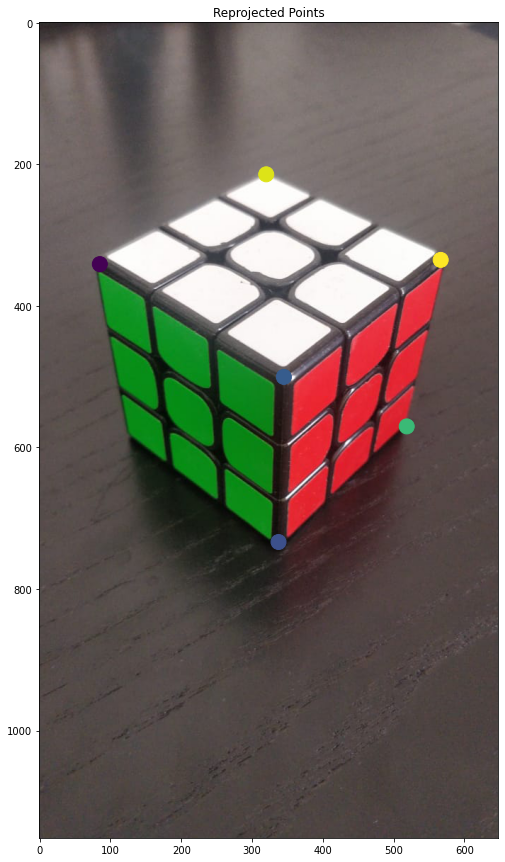

In [10]:
re_proj = get_points(P, X)
print('Image points with new P : \n', re_proj)
#code to plot these on the image
fig = plt.figure(figsize=(10,15))
img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area)
plt.title("Reprojected Points")
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [11]:
#Code for zhangs here
import numpy as np
import cv2
import glob
import shutil
import os

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

obj_points = [] # 3d world points
img_points = []

obj_w = np.zeros((8*6,3), np.float32)
obj_w[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

zhang_images = glob.glob('q1/Zhangs/*.JPG')
path = 'Zhang_out'
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path) 
i = 5455
for image in zhang_images:
    img = cv2.imread(image)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img_gray, (8,6),None)
    i = i+1
    if ret == True:
        obj_points.append(obj_w)

        corners2 = cv2.cornerSubPix(img_gray,corners,(11,11),(-1,-1),criteria)
        img_points.append(corners2)
        # Draw and display the corners
        img_corner = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
        #print(img_corner)
        cv2.imwrite('Zhang_out/IMG_'+ str(i) +'_corners.JPG', img_corner)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
reproj, K_mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_gray.shape[::-1],None,None)

print('Reprojection error : ',reproj , '\n')
print('K camera matrix using Zhang : \n', K_mtx , '\n')

Reprojection error :  2.288415145543705 

K camera matrix using Zhang : 
 [[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 



---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

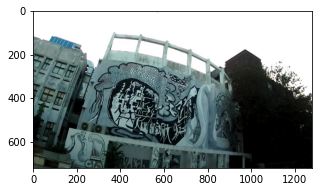

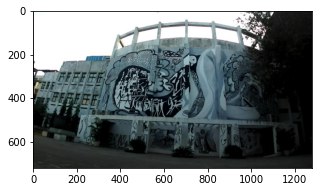

In [15]:
img1 = mpimg.imread('q2/img1.jpg')
fig = plt.figure(figsize=(5,5))
plt.imshow(img1)
img2 = mpimg.imread('q2/img2.jpg')
fig = plt.figure(figsize=(5,5))
plt.imshow(img2)

In [39]:
if os.path.exists('q2/image_points1.npy'):
    image_points1 = np.load('q2/image_points1.npy')
    print(image_points1)
else:
    img = mpimg.imread('q2/img1.jpg')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.plot(np.random.rand(6))
    text=ax.text(0,0, "", va="bottom", ha="left")
    image_points1 = []
    def onclick(event):
        tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        text.set_text(tx)
        image_points1.append([ event.xdata, event.ydata])

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    imgplot = plt.imshow(img)
    plt.show()

In [40]:
if not os.path.exists('q2/image_points1.npy'):
    N = len(image_points1)
    image_points1 = np.array(image_points1)
    np.save('q2/image_points1.npy',image_points1)
else:
    N = image_points1.shape[0]
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q2/img1.jpg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

print(image_points1.shape)
plt.scatter(image_points1[:,0], image_points1[:,1], c=colors, s=area)
plt.show()

(8, 2)


In [41]:
if os.path.exists('q2/image_points2.npy'):
    image_points2 = np.load('q2/image_points2.npy')
    print(image_points2)
else:
    img = mpimg.imread('q2/img2.jpg')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.plot(np.random.rand(6))
    text=ax.text(0,0, "", va="bottom", ha="left")
    image_points2 = []
    def onclick(event):
        tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        text.set_text(tx)
        image_points2.append([ event.xdata, event.ydata])

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    imgplot = plt.imshow(img)
    plt.show()

In [42]:
if not os.path.exists('q2/image_points2.npy'):
    N = len(image_points2)
    image_points2 = np.array(image_points2)
    np.save('q2/image_points2.npy',image_points2)
else:
    N = image_points2.shape[0]
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q2/img2.jpg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points2[:,0], image_points2[:,1], c=colors, s=area)
plt.show()

In [43]:
N = 8
def get_homogeneous_cord(image_points):
    return np.hstack([image_points,np.ones(image_points.shape[0]).reshape(-1,1)])

def normalize_image_points(image_points):# Homogeneous points
    centroid = np.mean(image_points,0)
    s = np.sqrt(2)/np.sqrt(np.sum((image_points - centroid)**2)/16)
    T = np.array([[s,0,-s*centroid[0]],[0,s,-s*centroid[1]],[0.0,0.0,1.0]])
    return T

def compute_fundamental_matrix(image_points1,image_points2):
    T1 = normalize_image_points(image_points1)
    T2 = normalize_image_points(image_points2)
    norm_image_points1 = np.dot(T1,image_points1.T).T
    norm_image_points2 = np.dot(T2,image_points2.T).T
    A = np.zeros((8,9))
    print(norm_image_points1.shape, norm_image_points2.shape)
    for i in range(N):
        A[i,:] = np.kron(norm_image_points1[i],norm_image_points2[i]).reshape(1,-1)
    U,D,Vt = np.linalg.svd(A)
    v12 = Vt.T[:,-1]
    F = v12.reshape(3,3)
    U_,D_,Vt_ = np.linalg.svd(F)
    F_norm = np.dot(U_,np.dot(np.diag((D_[0],D_[1],0.0)),Vt_))
    F_final = np.dot(T1.T,np.dot(F_norm,T2))
    F_final = F_final / F_final[2,2]
    return F_final

image1_epipole_lines = []
image2_epipole_lines = []

def plot1(img,F,image_points1,image_points2):
    cmap = plt.get_cmap('Paired')
    width = img.shape[1]
    for i in range(N):
        color = cmap(i)
        line = np.dot(F,image_points2[i]).reshape(-1,1)
        image1_epipole_lines.append(line)
        p1 = (0,-line[2]/line[1])
        p2 = (width,-(line[0]*width + line[2])/line[1])
        plt.plot(*zip(p1,p2),color = color)
        plt.plot(image_points1[i][:2][0],image_points1[i][:2][1],'o-',color = color)
    plt.imshow(img)

def plot2(img,F,image_points1,image_points2):
    cmap = plt.get_cmap('Paired')
    width = img.shape[1]
    for i in range(N):
        color = cmap(i)
        line = np.dot(F.T,image_points1[i]).reshape(-1,1)
        image2_epipole_lines.append(line)
        p1 = (0,-line[2]/line[1])
        p2 = (width,-(line[0]*width + line[2])/line[1])
        plt.plot(*zip(p1,p2),color = color)
        plt.plot(image_points2[i][:2][0],image_points2[i][:2][1],'o-',color = color)
    plt.imshow(img)

In [44]:
print(image_points1.shape, image_points2.shape)
image_points_homo1 = get_homogeneous_cord(image_points1)
image_points_homo2 = get_homogeneous_cord(image_points2)
print(image_points_homo1.shape, image_points_homo2.shape)
F = compute_fundamental_matrix(image_points_homo1,image_points_homo2)
plt.figure(figsize=(10,10))
# Plot for epipoles in image1
plot1(img1,F,image_points_homo1,image_points_homo2)

(8, 2) (8, 2)
(8, 3) (8, 3)
(8, 3) (8, 3)


In [45]:
plt.figure(figsize=(10,10))
#Plot for epipoles in image 2
plot2(img2,F,image_points_homo1,image_points_homo2)

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

In [46]:
def compute_epipole(F):
    Uf,Df,Vtf = np.linalg.svd(F)
    e = Vtf.T[:,-1]
    return e/e[2]
image1_epipole = compute_epipole(F.T)

image2_epipole = compute_epipole(F)

In [47]:
#image1 epipole
image1_epipole[:2]

array([586.74787299, 145.84817366])

In [48]:
#image2 epipole
image2_epipole[:2]

array([695.16352521,  73.56330176])

In [49]:
#epipolar lines intersect at the epipole
for i in range(1,len(image1_epipole_lines),1):
    intersection_of_epipolelines1 = np.cross(image1_epipole_lines[0].T,image1_epipole_lines[i].T)
    image1_epipole_inter = (intersection_of_epipolelines1/intersection_of_epipolelines1[0,2])[:,:2]
    print(image1_epipole_inter)

[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]
[[586.74787299 145.84817366]]


In [50]:
#epipolar lines intersect at the epipole
for i in range(1,len(image1_epipole_lines),1):
    intersection_of_epipolelines2 = np.cross(image2_epipole_lines[0].T,image2_epipole_lines[i].T)
    image2_epipole_inter = (intersection_of_epipolelines2/intersection_of_epipolelines2[0,2])[:,:2]
    print(image2_epipole_inter)

[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]
[[695.16352521  73.56330176]]


____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

In [56]:
# The 3D coordinates are :
# THE WORLD ORIGIN IS THE BOTTOM LEFT CORNER OF THE CAR.
world_cord = np.array([[0,0,0],[1.51,0,0],[1.51,0,4.1],[0,0,4.1],[1.51,-1.38,0],[1.51,-1.38,4.1],[0,-1.38,4.1],[0,-1.38,0]])
world_cord

array([[ 0.  ,  0.  ,  0.  ],
       [ 1.51,  0.  ,  0.  ],
       [ 1.51,  0.  ,  4.1 ],
       [ 0.  ,  0.  ,  4.1 ],
       [ 1.51, -1.38,  0.  ],
       [ 1.51, -1.38,  4.1 ],
       [ 0.  , -1.38,  4.1 ],
       [ 0.  , -1.38,  0.  ]])

In [57]:
K = np.array([[7.2153e+02,0,6.0955e+02],[0,7.2153e+02,1.7285e+02],[0,0,1]])
K

array([[721.53,   0.  , 609.55],
       [  0.  , 721.53, 172.85],
       [  0.  ,   0.  ,   1.  ]])

In [58]:
img = mpimg.imread('q3/image.png')
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
ax.plot(np.random.rand(6))
text=ax.text(0,0, "", va="bottom", ha="left")
image_points = []
def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    image_points.append([ event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)
imgplot = plt.imshow(img)
plt.show()

In [59]:
# world origin in image plane is 
W_image = np.hstack([image_points[0],1])

# Assuming the x-axis,y-axis and z-axis of the world frame align with that of the camera frame. This makes 
R = np.eye(3)
# world origin in camera frame given its coordinates in image plane is
t = np.dot(np.linalg.inv(K),W_image)

t = (t / t[1]) * 1.65 # Camera is 1.65m from ground(in negative y direction)
W_camera = - R * t
print(t)

#translation vector

P = np.dot(K,np.hstack([np.eye(3,3),t.reshape(-1,1)]))
#Projection matrix
print(P)

[ 2.59319059  1.65       13.21743815]
[[7.21530000e+02 0.00000000e+00 6.09550000e+02 9.92775423e+03]
 [0.00000000e+00 7.21530000e+02 1.72850000e+02 3.47515868e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.32174382e+01]]


In [60]:
bbox_points = np.dot(P,np.hstack([world_cord,np.ones(world_cord.shape[0]).reshape(-1,1)]).T)

In [61]:
bbox_points=bbox_points.T
bbox_points[:,0] = bbox_points[:,0]/bbox_points[:,2]
bbox_points[:,1] = bbox_points[:,1]/bbox_points[:,2]
bbox_points[:,2] = bbox_points[:,2]/bbox_points[:,2]

In [62]:
bbox_points

array([[751.11032258, 262.92225806,   1.        ],
       [833.54008602, 262.92225806,   1.        ],
       [780.50918476, 241.59714895,   1.        ],
       [717.59512723, 241.59714895,   1.        ],
       [833.54008602, 187.58909677,   1.        ],
       [780.50918476, 184.09953347,   1.        ],
       [717.59512723, 184.09953347,   1.        ],
       [751.11032258, 187.58909677,   1.        ]])

In [63]:

img_plot_points = np.array([bbox_points[i] for i in [0,1,4,7,0,3,2,1,4,5,6,7,6,3,2,5]])
fig = plt.figure(figsize=(10,15))
plt.plot(img_plot_points[:,0],img_plot_points[:,1],'o-')
plt.imshow(img)
plt.show()

In [64]:
# Assuming the mid point of the two rear wheels of the car in world frame as 
Mid_point_world = np.array([1.51/2,-0.1,1,1]) #Homogeneous coordinates
# This vector in camera frame is 
Mid_point_camera = np.dot(np.hstack([np.eye(3,3),t.reshape(-1,1)]),Mid_point_world)
# The midpoint of rear wheels as seen from the camera frame is 
Mid_point_camera

array([ 3.34819059,  1.55      , 14.21743815])

In [65]:
# This is same as t calculated above
world_to_camera_translation = Mid_point_camera - Mid_point_world[:3]
print(world_to_camera_translation)

[ 2.59319059  1.65       13.21743815]
